# Importing Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder, LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.utils import class_weight
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score


from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Reading Data

In [2]:
train_df = pd.read_csv("../input/customerattritionprediction/train.csv")
test_df = pd.read_csv("../input/customerattritionprediction/test.csv")

remove = True
remove_features = ['MobileService','HardwareSupport','Married','sex']

cat_features = ['Aged','TotalDependents','4GService','CyberProtection','TechnicalAssistance','FilmSubscription','SettlementProcess']
cont_features = ["QuarterlyPayment", "GrandPayment",'ServiceSpan']
label_col = ["CustomerAttrition"]
id_col = ["ID"]

if remove:
    train_df = train_df.drop(remove_features,axis = 1)
    test_df = test_df.drop(remove_features,axis = 1)
else:
    cat_features.extend(remove_features)
        

label_dict = {
    "Yes" : 1,
    "No" : 0
}
N_SPLITS = 9
train_df.head()

,ID,Aged,TotalDependents,ServiceSpan,4GService,CyberProtection,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment,CustomerAttrition
0,B60LHTZLLPFU4IULNPUF,No,Yes,48,Wifi Broadband,No,Yes,No,Check,96.259802,4628.129119,Yes
1,1RUJ7ONYZHYTWKOKO1SD,No,No,45,Wifi Broadband,No,No,Yes,Bank,18.876470,922.085998,No
2,DZ9EEOQWSN0MYCBUPAM5,Yes,No,59,Wifi Broadband,Yes,Yes,No,Card,106.016057,6205.891129,Yes
3,YZ43L1UQUQACTL1PXXZG,No,No,14,Wifi Broadband,No,No,No,Check,80.108839,1248.655391,No
4,6P28152QGF60PDLSCB9M,No,Yes,25,Wifi Broadband,No,No,Yes,Check,51.529773,1285.321277,No


# Preprocessing Function

In [3]:
#cat_encoder = OneHotEncoder()
cat_encoders = {}
cont_encoder = MinMaxScaler()
#cont_encoder = StandardScaler()

def preprocess_df(df, cat_features, cont_features, data = "train"):
    for col in cat_features:
        if data == "train":
            cat_encoder = LabelEncoder()
            df[col] = cat_encoder.fit_transform(df[col])
            cat_encoders[col] = cat_encoder
        else:
            df[col] = cat_encoders[col].transform(df[col])
            
    if data == "train":
        df[cont_features] = cont_encoder.fit_transform(df[cont_features])
    else:
        df[cont_features] = cont_encoder.transform(df[cont_features])
    return df

# Preprocessing Data

In [4]:
train_df[label_col[0]] = train_df[label_col[0]].map(label_dict)

train_df = preprocess_df(train_df, cat_features, cont_features, data = "train")

labels = train_df[label_col[0]]
train_ds = train_df.drop(label_col + id_col, axis = 1)
tot_features = list(train_ds.columns)
cat_ids = []

for i, col in enumerate(tot_features):
    if col in cat_features:
        cat_ids.append(i)
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(labels.values),
                                                 y = labels.values)
train_ds.head()

,Aged,TotalDependents,ServiceSpan,4GService,CyberProtection,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment
0,0,1,0.666667,2,0,1,0,2,0.769434,0.531957
1,0,0,0.626667,2,0,0,1,0,0.022887,0.104479
2,1,0,0.813333,2,1,1,0,1,0.863556,0.713946
3,0,0,0.213333,2,0,0,0,2,0.613619,0.142148
4,0,1,0.360000,2,0,0,1,2,0.337906,0.146377


In [5]:
test_df = preprocess_df(test_df, cat_features, cont_features, data = "test")

test_ids = test_df["ID"]
test_ds = test_df.drop(id_col, axis = 1)
test_df.head()

,ID,Aged,TotalDependents,ServiceSpan,4GService,CyberProtection,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment
0,WMORTPCG3HTIPEFSGUFY,0,0,0.133333,2,0,0,1,2,0.046267,0.015548
1,GBLPEA16C3KGBO57KEFO,0,0,0.373333,1,0,0,1,2,0.386913,0.177285
2,IDCQS0CO5P29AMKY3LO1,0,0,0.906667,1,0,0,1,1,0.083581,0.192393
3,1IY29SDITYU6IFZ4KJB0,1,0,0.440000,1,0,1,1,0,0.376796,0.209189
4,T5XMW5B0YPCONH30WJD2,0,1,0.306667,1,0,0,0,0,0.034402,0.054619


In [6]:
roc_scores = np.zeros((N_SPLITS*4))
test_pred = {}
num = 0

# CatBoost

In [7]:
SEED = 143
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
count = 0
cb_best = 0
feature_imp_cb = 0
cb_score = 0
roc_cb_scores = np.zeros((N_SPLITS))
cb_pred = {}

for train_idx,test_idx in kfold.split(train_ds,labels):
    print(' Running {} of KFold {}'.format(count+1,kfold.n_splits))
    xtr,xvl = train_ds.loc[train_idx],train_ds.loc[test_idx]
    ytr,yvl = labels.loc[train_idx],labels.loc[test_idx]
    
    cb_model = CatBoostClassifier(
                        verbose=100,
                        eval_metric="Accuracy",
                        loss_function="Logloss",
                        random_state=2021,
                        num_boost_round=20000,
                        od_type="Iter",
                        od_wait=200,
                        cat_features=cat_ids,
                        bagging_temperature=1.288692494969795,
                        grow_policy="Depthwise",
                        l2_leaf_reg=9.847870133539244,
                        learning_rate=0.01877982653902465,
                        max_depth=8,
                        min_data_in_leaf=1,
                        penalties_coefficient=2.1176668909602734,
            )
    cb_model.fit(xtr,ytr,eval_set=(xvl,yvl))
    cb_best += cb_model.predict_proba(test_ds)
    cb_pred[count] = cb_model.predict_proba(test_ds)
    
    roc_cb_scores[count] = roc_auc_score(yvl,cb_model.predict_proba(xvl)[:,-1], average="macro")
    cb_score += roc_auc_score(yvl,cb_model.predict_proba(xvl)[:,-1], average="macro")
    
    print("CB - ROC AUC Score = {}".format(roc_auc_score(yvl,cb_model.predict_proba(xvl)[:,-1], average="macro")))
    feature_imp_cb += cb_model.feature_importances_
    
    roc_scores[num*N_SPLITS + count] = roc_auc_score(yvl,cb_model.predict_proba(xvl)[:,-1], average="macro")
    test_pred[num*N_SPLITS + count] = cb_model.predict_proba(test_ds)
    count+=1

cb_score = cb_score/N_SPLITS
cb_best = cb_best/N_SPLITS
feature_imp_cb = list(feature_imp_cb/N_SPLITS)
num +=1

 Running 1 of KFold 9
0:	learn: 0.8008166	test: 0.7886525	best: 0.7886525 (0)	total: 78.5ms	remaining: 26m 9s
100:	learn: 0.8176815	test: 0.8113475	best: 0.8141844 (88)	total: 1.47s	remaining: 4m 49s
200:	learn: 0.8240724	test: 0.8056738	best: 0.8141844 (88)	total: 2.88s	remaining: 4m 43s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8141843972
bestIteration = 88

Shrink model to first 89 iterations.
CB - ROC AUC Score = 0.8298164474635062
 Running 2 of KFold 9
0:	learn: 0.8045446	test: 0.7716312	best: 0.7716312 (0)	total: 14.3ms	remaining: 4m 46s
100:	learn: 0.8187467	test: 0.7872340	best: 0.7900709 (45)	total: 1.42s	remaining: 4m 39s
200:	learn: 0.8265578	test: 0.7872340	best: 0.7943262 (163)	total: 2.73s	remaining: 4m 29s
300:	learn: 0.8322386	test: 0.7886525	best: 0.7943262 (163)	total: 3.98s	remaining: 4m 20s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7943262411
bestIteration = 163

Shrink model to first 164 iterations.
CB - ROC AUC

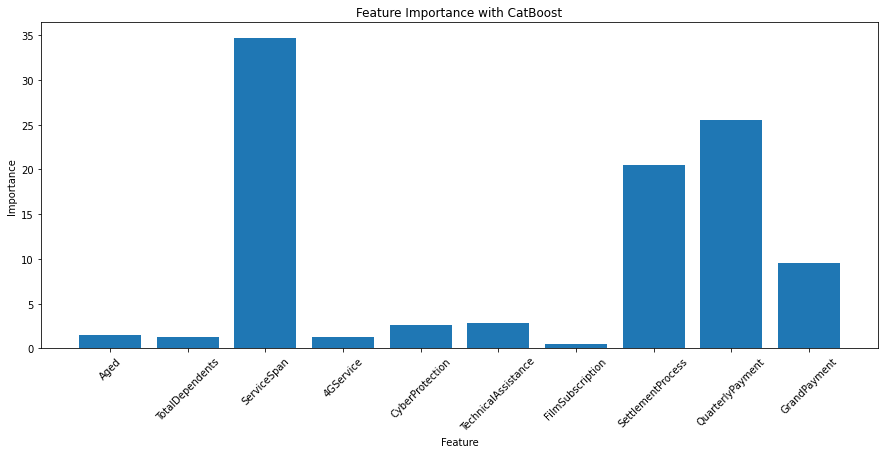

In [8]:
#Feature Importances

plt.figure(figsize = (15,6))
plt.bar(tot_features,feature_imp_cb)
plt.title("Feature Importance with CatBoost")
plt.xlabel("Feature")
plt.xticks(rotation = 45)
plt.ylabel("Importance")
plt.show()

# LightGBM

In [9]:
count = 0
lgb_best = 0
feature_imp_lgb = 0
lgb_score = 0
roc_lgb_scores = np.zeros((N_SPLITS))
lgb_pred = {}

for train_idx,test_idx in kfold.split(train_ds,labels):
    print(' Running {} of KFold {}'.format(count+1,kfold.n_splits))
    xtr,xvl = train_ds.loc[train_idx],train_ds.loc[test_idx]
    ytr,yvl = labels.loc[train_idx],labels.loc[test_idx]
    
    lgb_model = LGBMClassifier(
               n_estimators = 1000,
               cat_feature=cat_ids,
               metric = "auc"
    )
    
    lgb_model.fit(xtr,ytr,eval_set=[(xvl,yvl)], verbose = 500)
    lgb_best += lgb_model.predict_proba(test_ds)
    lgb_pred[count] = lgb_model.predict_proba(test_ds)
    
    roc_lgb_scores[count] = roc_auc_score(yvl,lgb_model.predict_proba(xvl)[:,-1], average="macro")
    lgb_score += roc_auc_score(yvl,lgb_model.predict_proba(xvl)[:,-1], average="macro")
    print("LGB - ROC AUC Score = {}".format(roc_auc_score(yvl,lgb_model.predict_proba(xvl)[:,-1], average="macro")))
    feature_imp_lgb += lgb_model.feature_importances_
    
    roc_scores[num*N_SPLITS + count] = roc_auc_score(yvl,lgb_model.predict_proba(xvl)[:,-1], average="macro")
    test_pred[num*N_SPLITS + count] = lgb_model.predict_proba(test_ds)
    count+=1

lgb_score = lgb_score/N_SPLITS
lgb_best = lgb_best/N_SPLITS
feature_imp_lgb = list(feature_imp_lgb/N_SPLITS)
num+=1

 Running 1 of KFold 9
[500]	valid_0's auc: 0.810945
[1000]	valid_0's auc: 0.803729
LGB - ROC AUC Score = 0.803728862552392
 Running 2 of KFold 9
[500]	valid_0's auc: 0.771819
[1000]	valid_0's auc: 0.767586
LGB - ROC AUC Score = 0.7675861499390911
 Running 3 of KFold 9
[500]	valid_0's auc: 0.803256
[1000]	valid_0's auc: 0.792592
LGB - ROC AUC Score = 0.7925919796439765
 Running 4 of KFold 9
[500]	valid_0's auc: 0.809648
[1000]	valid_0's auc: 0.798881
LGB - ROC AUC Score = 0.7988808324455157
 Running 5 of KFold 9
[500]	valid_0's auc: 0.778194
[1000]	valid_0's auc: 0.773725
LGB - ROC AUC Score = 0.773725421239359
 Running 6 of KFold 9
[500]	valid_0's auc: 0.806018
[1000]	valid_0's auc: 0.79585
LGB - ROC AUC Score = 0.795850184631616
 Running 7 of KFold 9
[500]	valid_0's auc: 0.793499
[1000]	valid_0's auc: 0.78148
LGB - ROC AUC Score = 0.781479636318346
 Running 8 of KFold 9
[500]	valid_0's auc: 0.834735
[1000]	valid_0's auc: 0.825964
LGB - ROC AUC Score = 0.8259642130609871
 Running 9 of 

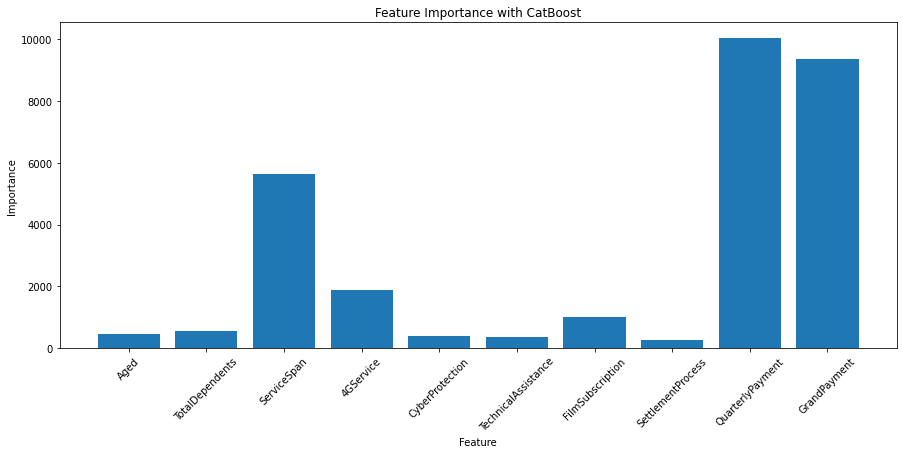

In [10]:
#Feature Importances

plt.figure(figsize = (15,6))
plt.bar(tot_features,feature_imp_lgb)
plt.title("Feature Importance with CatBoost")
plt.xlabel("Feature")
plt.xticks(rotation = 45)
plt.ylabel("Importance")
plt.show()

# XGBoost

In [11]:
count = 0
xgb_best = 0
feature_imp_xgb = 0
xgb_score = 0
roc_xgb_scores = np.zeros((N_SPLITS))
xgb_pred = {}

for train_idx,test_idx in kfold.split(train_ds,labels):
    print(' Running {} of KFold {}'.format(count+1,kfold.n_splits))
    xtr,xvl = train_ds.loc[train_idx],train_ds.loc[test_idx]
    ytr,yvl = labels.loc[train_idx],labels.loc[test_idx]
    
    xgb_model = XGBClassifier(
               use_label_encoder = False,
               eval_metric = "auc"
    )
    xgb_model.fit(xtr,ytr,eval_set=[(xvl,yvl)], verbose = 500)
    xgb_best += xgb_model.predict_proba(test_ds)
    xgb_pred[count] = xgb_model.predict_proba(test_ds)
    
    roc_xgb_scores[count] = roc_auc_score(yvl,xgb_model.predict_proba(xvl)[:,-1], average="macro")
    xgb_score += roc_auc_score(yvl,xgb_model.predict_proba(xvl)[:,-1], average="macro")
    print("XGB - ROC AUC Score = {}".format(roc_auc_score(yvl,xgb_model.predict_proba(xvl)[:,-1], average="macro")))
    feature_imp_xgb += np.array(list(xgb_model.get_booster().get_score(importance_type='weight').values()))
    
    roc_scores[num*N_SPLITS + count] = roc_auc_score(yvl,xgb_model.predict_proba(xvl)[:,-1], average="macro")
    test_pred[num*N_SPLITS + count] = xgb_model.predict_proba(test_ds)
    count+=1
    
xgb_score = xgb_score/N_SPLITS
xgb_best = xgb_best/N_SPLITS
feature_imp_xgb = list(feature_imp_xgb/N_SPLITS)
num+=1

 Running 1 of KFold 9
[0]	validation_0-auc:0.80704
[99]	validation_0-auc:0.82061
XGB - ROC AUC Score = 0.8206078500196147
 Running 2 of KFold 9
[0]	validation_0-auc:0.80758


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will gen

[99]	validation_0-auc:0.79244
XGB - ROC AUC Score = 0.7924452336217043
 Running 3 of KFold 9
[0]	validation_0-auc:0.79873


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will gen

[99]	validation_0-auc:0.80542
XGB - ROC AUC Score = 0.8054179294365892
 Running 4 of KFold 9
[0]	validation_0-auc:0.81903


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will gen

[99]	validation_0-auc:0.82369
XGB - ROC AUC Score = 0.8236949078910621
 Running 5 of KFold 9
[0]	validation_0-auc:0.79435


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will gen

[99]	validation_0-auc:0.79376
XGB - ROC AUC Score = 0.7937607960363677
 Running 6 of KFold 9
[0]	validation_0-auc:0.81153


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will gen

[99]	validation_0-auc:0.81525
XGB - ROC AUC Score = 0.8152546054468912
 Running 7 of KFold 9
[0]	validation_0-auc:0.82964


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will gen

[99]	validation_0-auc:0.80904
XGB - ROC AUC Score = 0.8090411840411841
 Running 8 of KFold 9
[0]	validation_0-auc:0.83931


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will gen

[99]	validation_0-auc:0.84713
XGB - ROC AUC Score = 0.8471270809980487
 Running 9 of KFold 9
[0]	validation_0-auc:0.79341


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will gen

[99]	validation_0-auc:0.79381
XGB - ROC AUC Score = 0.7938099389712294


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will gen

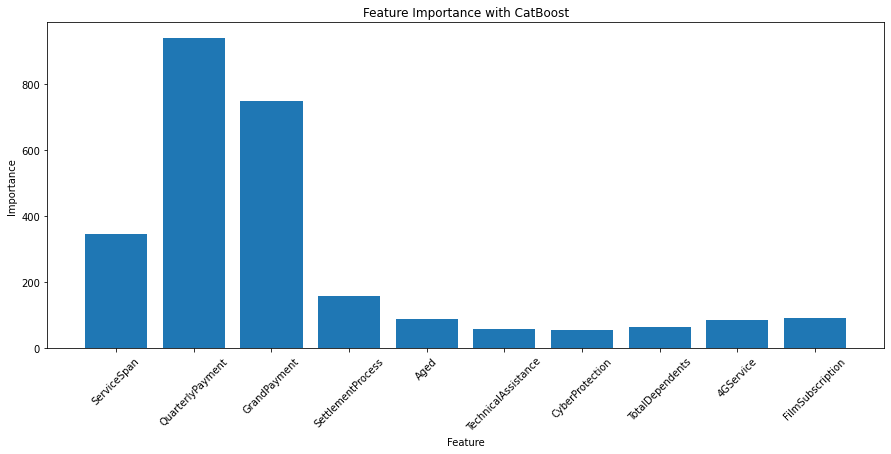

In [12]:
#Feature Importances

features = list(xgb_model.get_booster().get_score(importance_type='weight').keys())
plt.figure(figsize = (15,6))
plt.bar(features,feature_imp_xgb)
plt.title("Feature Importance with CatBoost")
plt.xlabel("Feature")
plt.xticks(rotation = 45)
plt.ylabel("Importance")
plt.show()

# Scikit-Learn

In [13]:
count = 0
hgb_best = 0
hgb_score = 0
roc_hgb_scores = np.zeros((N_SPLITS))
hgb_pred = {}

for train_idx,test_idx in kfold.split(train_ds,labels):
    print(' Running {} of KFold {}'.format(count+1,kfold.n_splits))
    xtr,xvl = train_ds.loc[train_idx],train_ds.loc[test_idx]
    ytr,yvl = labels.loc[train_idx],labels.loc[test_idx]
    
    hgb_model = HistGradientBoostingClassifier(
                    l2_regularization=1.766059063693552,
                    learning_rate=0.10675193678150449,
                    max_bins=128,
                    max_depth=31,
                    max_leaf_nodes=185,
                    random_state=2021,
                    verbose = 0
            )
    hgb_model.fit(xtr,ytr)
    
    roc_hgb_scores[count] = roc_auc_score(yvl,hgb_model.predict_proba(xvl)[:,-1], average="macro")
    hgb_score += roc_auc_score(yvl,hgb_model.predict_proba(xvl)[:,-1], average="macro")
    print("HGB - ROC AUC Score = {}".format(roc_auc_score(yvl,hgb_model.predict_proba(xvl)[:,-1], average="macro")))
    hgb_best += hgb_model.predict_proba(test_ds)
    hgb_pred[count] = hgb_model.predict_proba(test_ds)
    
    roc_scores[num*N_SPLITS + count] = roc_auc_score(yvl,hgb_model.predict_proba(xvl)[:,-1], average="macro")
    test_pred[num*N_SPLITS + count] = hgb_model.predict_proba(test_ds)
    count+=1

hgb_score = hgb_score/N_SPLITS
hgb_best = hgb_best/N_SPLITS

 Running 1 of KFold 9
HGB - ROC AUC Score = 0.8203600850659674
 Running 2 of KFold 9
HGB - ROC AUC Score = 0.7973592385357091
 Running 3 of KFold 9
HGB - ROC AUC Score = 0.8015494574830109
 Running 4 of KFold 9
HGB - ROC AUC Score = 0.8101759430693326
 Running 5 of KFold 9
HGB - ROC AUC Score = 0.7729393146391668
 Running 6 of KFold 9
HGB - ROC AUC Score = 0.810734492495785
 Running 7 of KFold 9
HGB - ROC AUC Score = 0.7909349441607505
 Running 8 of KFold 9
HGB - ROC AUC Score = 0.8435463112882469
 Running 9 of KFold 9
HGB - ROC AUC Score = 0.7962282559056753


In [14]:
print("Final XGB score : ",xgb_score)
print("Final LGB score : ",lgb_score)
print("Final CB score : ",cb_score)
print("Final HGB score : ",hgb_score)

Final XGB score :  0.8112399473847435
Final LGB score :  0.791542408534323
Final CB score :  0.8293764523307317
Final HGB score :  0.8048697825159604


# Predictions

In [15]:
#pred_test_full = (cb_best + xgb_best + hgb_best + lgb_best) / 4
#pred_test_full = cb_best

pred_test_full = 0
top = 5
indices = np.argpartition(roc_scores, -1*top)[-1*top:]

for i in indices:
    pred_test_full += test_pred[i]
    print("Considering model with ROC: ",roc_scores[i])
pred_test_full = pred_test_full/top

label_dict = {
    1 : "Yes" ,
    0 : "No"
}
pred = [label_dict[np.argmax(i)] for i in pred_test_full]

predictions = {
    id_col[0] : test_ids,
    label_col[0] : pred
}
pred_df = pd.DataFrame.from_dict(predictions)
pred_df.to_csv("./submission.csv", index = False)
print(pred_df[label_col[0]].value_counts())
pred_df.head()

Considering model with ROC:  0.8327196185314288
Considering model with ROC:  0.8435463112882469
Considering model with ROC:  0.8471270809980487
Considering model with ROC:  0.851994851994852
Considering model with ROC:  0.8691306513887158
No     559
Yes    146
Name: CustomerAttrition, dtype: int64


,ID,CustomerAttrition
0,WMORTPCG3HTIPEFSGUFY,No
1,GBLPEA16C3KGBO57KEFO,No
2,IDCQS0CO5P29AMKY3LO1,No
3,1IY29SDITYU6IFZ4KJB0,No
4,T5XMW5B0YPCONH30WJD2,No
